# Прогнозирование вероятности оттока пользователей для фитнес-центров.

### План проекта
 
1.[Открыть файл с данными и изучить общую информацию](#cell1)

2.[Исследовательский анализ данных](#cell2)

3.[Модель прогнозирования оттока клиентов](#cell3)

4.[Кластеризация клиентов](#cell4)

5.[Выводы и базовые рекомендации по работе с клиентами](#cell5)


### Открыть файл с данными и изучить общую информацию.
<a id='cell1'></a>

4.1 Импорт необходимых библиотек.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

4.2 Сохранение данных в переменной gym_df.

In [2]:
gym_df = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn.csv')

4.3 Ознакомление с данными используя методы head(), info(), describe().

In [3]:
gym_df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
gym_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [5]:
pd.set_option('display.float_format', '{:,.2f}'.format)
gym_df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
gender,"4,000.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
Near_Location,"4,000.00",0.85,0.36,0.00,1.00,1.00,1.00,1.00
Partner,"4,000.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00
Promo_friends,"4,000.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00
Phone,"4,000.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
Contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,6.00,12.00
Group_visits,"4,000.00",0.41,0.49,0.00,0.00,0.00,1.00,1.00
Age,"4,000.00",29.18,3.26,18.00,27.00,29.00,31.00,41.00
Avg_additional_charges_total,"4,000.00",146.94,96.36,0.15,68.87,136.22,210.95,552.59
Month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,6.00,12.00


Вывод: Часть переменных в датасете бинарные(gender, near_location, partner, promo_friends, phone, group_visits, churn) ,остальная часть — количественные(contract_period, age, avg_additional_charges_total, month_to_end_contract, lifetime, avg_class_frequency_tota, avg_class_frequency_current_month).

Тип данных соответсвует необходимому и не требует исправлений. Аномальных значений в датасете не наблюдается. Глядя на максимальные показатели можно сказать, что есть клиенты которые давно ходят в зал и есть клиенты которые платят большие суммы за доп услуги в зале.

### Исследовательский анализ данных.
<a id='cell2'></a>

5.1 Проверка на дубликаты и пропущенные значения.

In [6]:
gym_df.duplicated().sum()

0

In [7]:
gym_df.isnull().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Вывод: дубликаты и пропущенные значения отсутствуют в данном датасете.

5.2 Установка нижнего регистра в названиях столбцов.

In [8]:
gym_df.columns = gym_df.columns.str.lower()

5.3 Проверка средних значений признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [9]:
churn_out = gym_df.query('churn == 1')
churn_in = gym_df.query('churn == 0')
print('\nУшедшие в отток: {:.2f}'.format(len(churn_out)))
print('\nДоля ушедших в отток: {:.2f}'.format(len(churn_out)/len(gym_df)))
print('\nОставшиеся: {:.2f}'.format(len(churn_in)))
print('\nДоля оставшихся: {:.2f}'.format(len(churn_in)/len(gym_df)))


Ушедшие в отток: 1061.00

Доля ушедших в отток: 0.27

Оставшиеся: 2939.00

Доля оставшихся: 0.73


In [10]:
gym_df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.90,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.90,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


Вывод: В отток ушли люди у которых все признаки имеют меньший показатель по сравнению с теми кто остался, ключевыми тут можно считать 'near_location' - проживание или работа в районе, где находится фитнес-центр, явно что чем ближе фитнес центр тем удобнее его посещение, 'Group_visits' - групповые занятия сплачивают и привлекают к частому посещению фитнес центра, 'Partner' - скидка на абонемент несомненно играет большую роль для привлечения клиента.

5.4 Проверка признаков.

* Ушедшие.

In [11]:
pd.set_option('display.float_format', '{:,.2f}'.format)
churn_out.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
gender,"1,061.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,"1,061.00",0.77,0.42,0.00,1.00,1.00,1.00,1.00
partner,"1,061.00",0.36,0.48,0.00,0.00,0.00,1.00,1.00
promo_friends,"1,061.00",0.18,0.39,0.00,0.00,0.00,0.00,1.00
phone,"1,061.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,"1,061.00",1.73,2.13,1.00,1.00,1.00,1.00,12.00
group_visits,"1,061.00",0.27,0.44,0.00,0.00,0.00,1.00,1.00
age,"1,061.00",26.99,2.90,18.00,25.00,27.00,29.00,38.00
avg_additional_charges_total,"1,061.00",115.08,77.70,0.15,50.63,103.81,165.62,425.54
month_to_end_contract,"1,061.00",1.66,1.96,1.00,1.00,1.00,1.00,12.00


* Оставшиеся.

In [12]:
pd.set_option('display.float_format', '{:,.2f}'.format)
churn_in.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
gender,"2,939.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,"2,939.00",0.87,0.33,0.00,1.00,1.00,1.00,1.00
partner,"2,939.00",0.53,0.50,0.00,0.00,1.00,1.00,1.00
promo_friends,"2,939.00",0.35,0.48,0.00,0.00,0.00,1.00,1.00
phone,"2,939.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,"2,939.00",5.75,4.72,1.00,1.00,6.00,12.00,12.00
group_visits,"2,939.00",0.46,0.50,0.00,0.00,0.00,1.00,1.00
age,"2,939.00",29.98,3.01,19.00,28.00,30.00,32.00,41.00
avg_additional_charges_total,"2,939.00",158.45,99.80,0.17,76.92,149.88,224.45,552.59
month_to_end_contract,"2,939.00",5.28,4.36,1.00,1.00,6.00,10.00,12.00


In [13]:
#pip install -U seaborn

Гистограммы плотностей распределений(для бинарных признаков и признаков с малым числом принимаемых значений).

<Figure size 720x288 with 0 Axes>

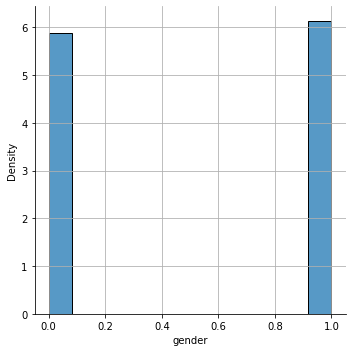

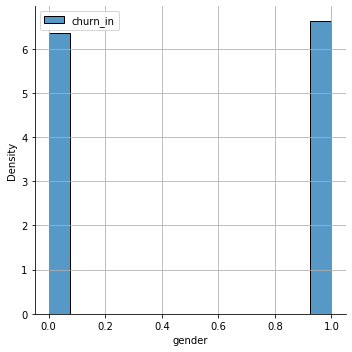

<Figure size 720x288 with 0 Axes>

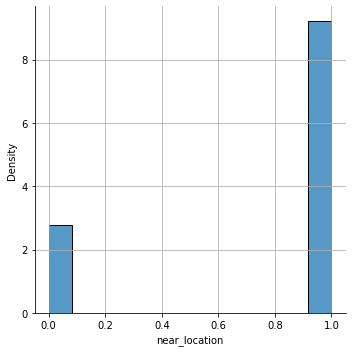

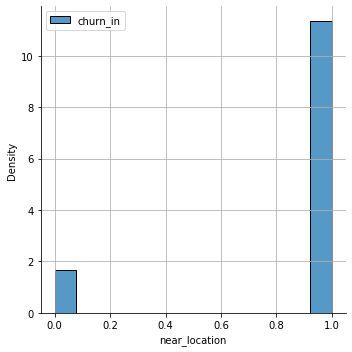

<Figure size 720x288 with 0 Axes>

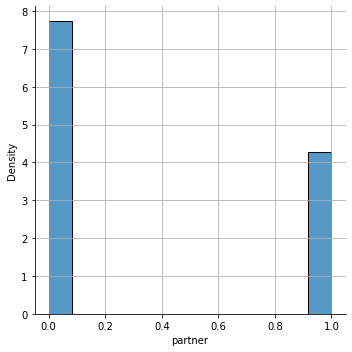

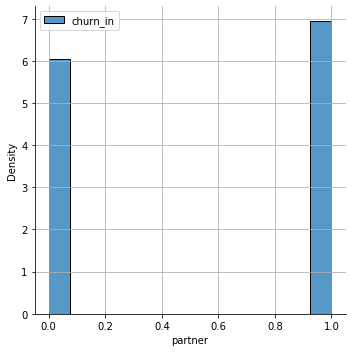

<Figure size 720x288 with 0 Axes>

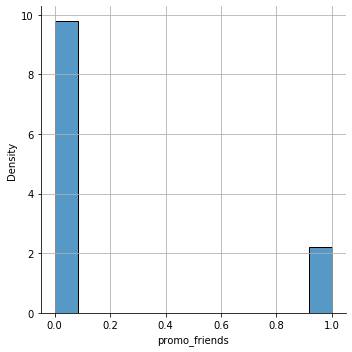

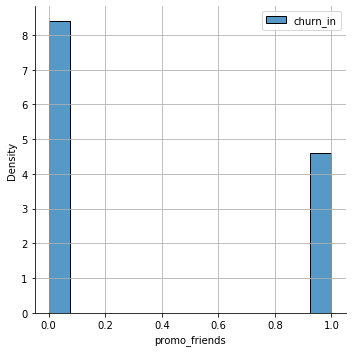

<Figure size 720x288 with 0 Axes>

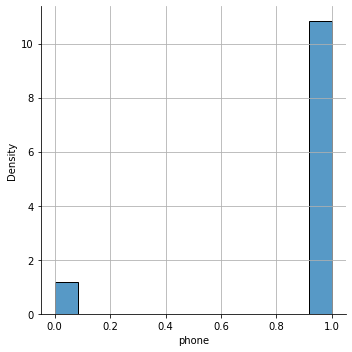

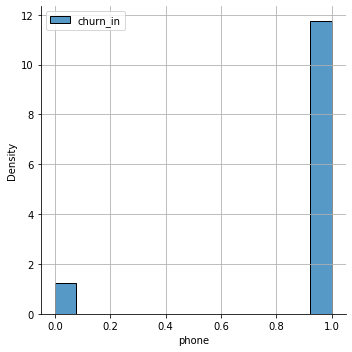

<Figure size 720x288 with 0 Axes>

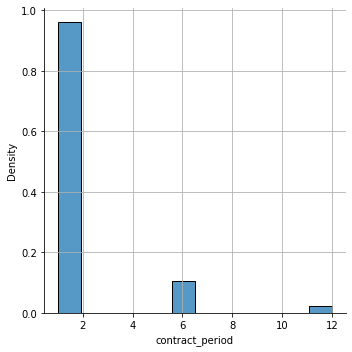

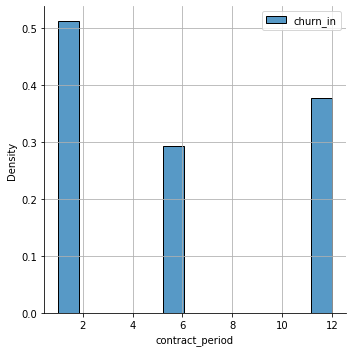

<Figure size 720x288 with 0 Axes>

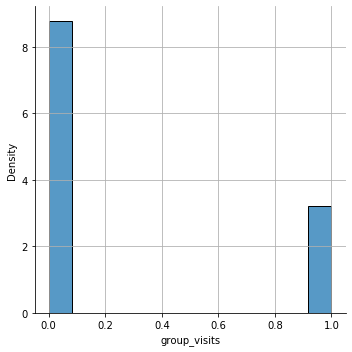

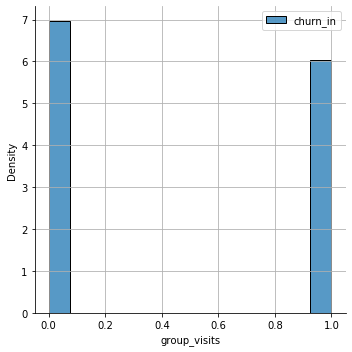

<Figure size 720x288 with 0 Axes>

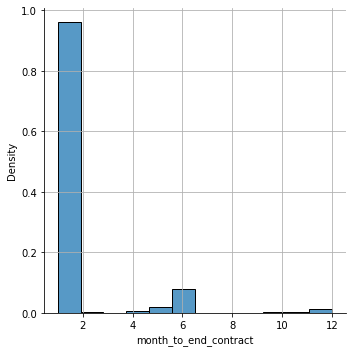

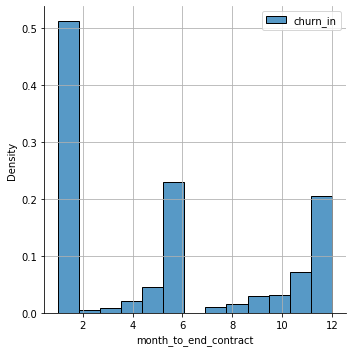

<Figure size 720x288 with 0 Axes>

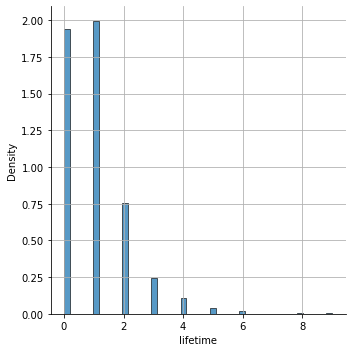

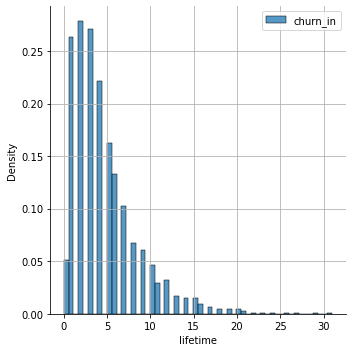

In [14]:
columns = ('gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'month_to_end_contract', 'lifetime')
for i in columns:
    plt.figure(figsize=(10,4));
    sns.displot(churn_out, x=i, hue='churn', stat="density", label='churn_out', common_norm=False, hue='churn');
    plt.legend()
    plt.grid()
    sns.displot(churn_in, x=i, stat="density", label='churn_in', common_norm=False);
    plt.grid()
    plt.legend()
    plt.show()

Гистограммы и кривые плотностей распределений(для остальных признаков).

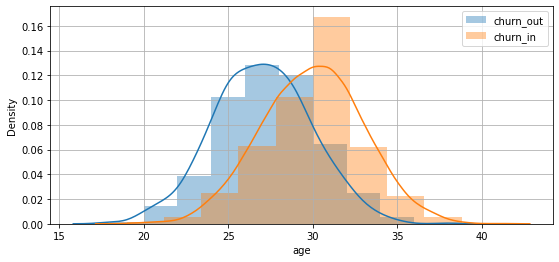

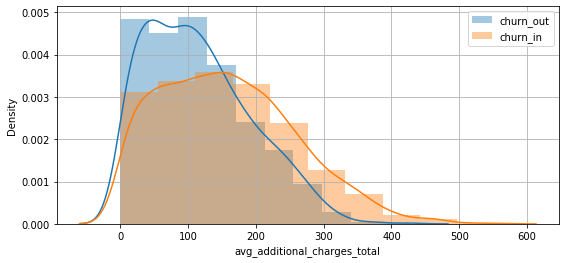

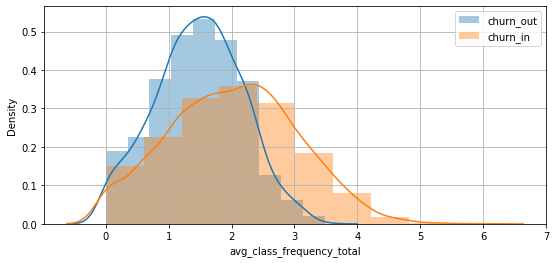

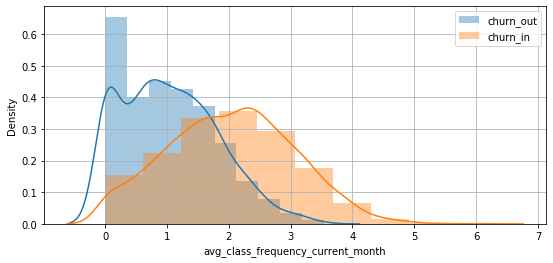

In [15]:
columns = ('age', 'avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month')
for i in columns:
    plt.figure(figsize=(9,4))
    plt.grid()
    sns.distplot(churn_out[i], bins=10, label='churn_out')
    sns.distplot(churn_in[i], bins=10, label='churn_in')
    plt.legend()
    plt.show()

5.5 Матрица корреляций.

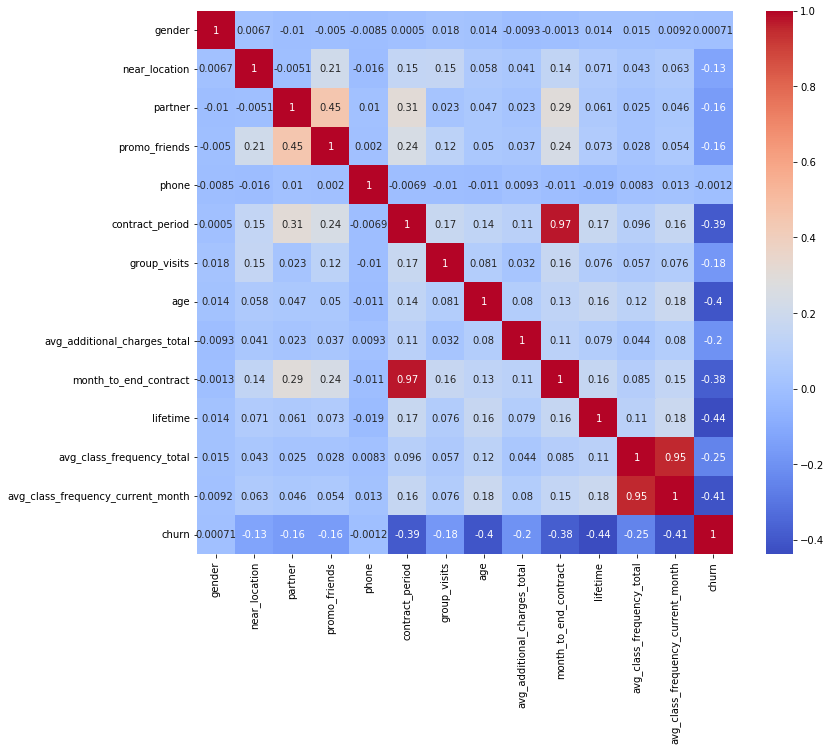

In [16]:
plt.figure(figsize=(12,10))
sns.heatmap(gym_df.corr(), cmap='coolwarm', annot=True);

Вывод: Корреляция имеется у схожих признаков, особенно сильно коррелируют показатели 'avg_class_frequency_current_month' и 'avg_class_frequency_total'; 'month_to_end_contract' и 'contract_period' это двольно сильно зависимые признаки, имеется и отрицательная корреляция она имеет обратную взаимосвзяь т.е когда растет одна величина, другая падает.

### Модель прогнозирования оттока клиентов
<a id='cell3'></a>

6.1 Разделим наши данные на признаки (матрица X) и целевую переменную (y).Далее разделим модель на обучающую и валидационную выборку.

In [17]:
X = gym_df.drop('churn', axis=1)
y = gym_df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

* Логистическая регрессия.

In [18]:
# задаем алгоритм для нашей модели
model_logistic = LogisticRegression(solver='liblinear', random_state=0)
# обучаем модель
model_logistic.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions_logistic = model_logistic.predict(X_test)
probabilities_logistic = model_logistic.predict_proba(X_test)[:,1]

* Случайный лес.

In [19]:
# задаем алгоритм для нашей модели
model_forest = RandomForestClassifier(n_estimators=100, random_state=0)
# обучаем модель
model_forest.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions_forest = model_forest.predict(X_test)
probabilities_forest = model_forest.predict_proba(X_test)[:,1]

* Оценка метрик accuracy(доля правильных ответов), precision(точность) и recall(полнота) для обеих моделей на валидационной выборке.

Вывод метрик.

In [20]:
logistic_regression_list = [['Accuracy(доля правильных ответов)', accuracy_score(y_test, predictions_logistic)],
                           ['Precision(точность)', precision_score(y_test, predictions_logistic)],
                            ['Recall(полнота)', recall_score(y_test, predictions_logistic)], 
                            ]

In [21]:
print('Метрики для логистической регрессии       | Значение           |')
print('-----------------------------------------------------------------')

for row in logistic_regression_list:

    print('{: <41} | {: >20} '.format(row[0], row[1]))

Метрики для логистической регрессии       | Значение           |
-----------------------------------------------------------------
Accuracy(доля правильных ответов)         |                0.925 
Precision(точность)                       |   0.8631578947368421 
Recall(полнота)                           |   0.8282828282828283 


In [22]:
random_forest_classifier_list = [['Accuracy(доля правильных ответов)', accuracy_score(y_test, predictions_forest)],
                           ['Precision(точность)', precision_score(y_test, predictions_forest)],
                            ['Recall(полнота)', recall_score(y_test, predictions_forest)], 
                            ]

In [23]:
print('Метрики для модели случайного леса       | Значение           |')
print('---------------------------------------------------------------')

for row in random_forest_classifier_list:

    print('{: <40} | {: >20} '.format(row[0], row[1]))

Метрики для модели случайного леса       | Значение           |
---------------------------------------------------------------
Accuracy(доля правильных ответов)        |              0.91625 
Precision(точность)                      |   0.8393782383419689 
Recall(полнота)                          |   0.8181818181818182 


Вывод: Метрика Accuracy - это доля верно угаданных ответов из всех прогнозов и чем ближе значение accuracy к 100%, тем лучше.
Для логистической регрессии этот показатель 0.925, для случайного леса 0.91625.

Метрики Precision(точность) и Recall(полнота). Каждая метрика принимает значения от 0 до 1. Чем ближе к единице, тем лучше, 
Для логистической регрессии эти показатели 0.863 и 0.828, для случайного леса 0.839 и 0.818.

Модель логистической регрессии показала себя немного лучше чем модель случайного леса.

### Кластеризация клиентов.
<a id='cell4'></a>

7.1 Выполним стандартизацию и передадим получившуюся стандартизированную таблицу в качестве параметра функции linkage().

In [24]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 

7.2 В переменной linked сохранена таблица «связок» между объектами. Визуализируем используя dendogram().

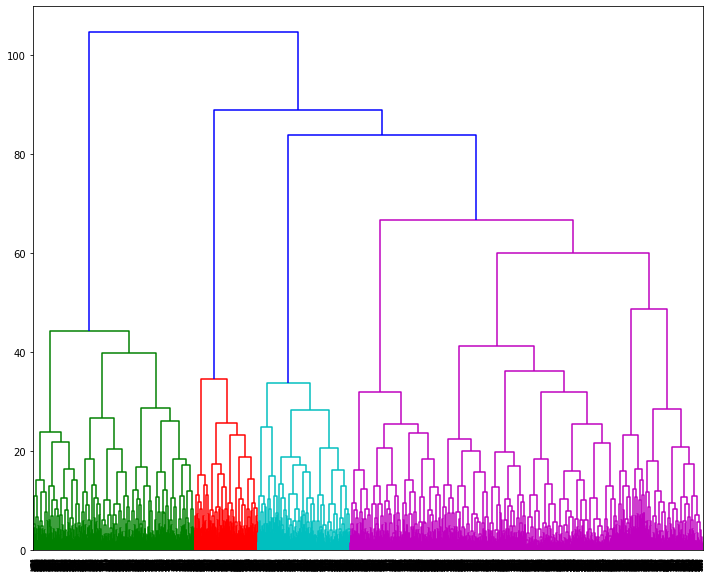

In [25]:
plt.figure(figsize=(12,10))  
dendrogram(linked, orientation='top')
plt.show()

Предложенное оптимальное число кластеров 4 — 4 разных цвета на графике.

7.3 Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Посмотрим на средние значения признаков для кластеров.

In [26]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений 
labels = km.fit_predict(X_sc)
# сохраняем метки кластера в поле нашего датасета
gym_df['cluster_km'] = labels
# выводим статистику по средним значениям наших признаков по кластеру
gym_df.groupby('cluster_km').mean().round(2).sort_values(by='contract_period', ascending=False)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.50,0.96,0.78,0.57,1.00,10.88,0.54,29.98,160.71,9.95,4.74,1.98,1.98,0.03
1,0.52,0.86,0.47,0.31,0.00,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72,0.27
4,0.56,0.98,0.36,0.23,1.00,2.67,0.47,30.13,161.72,2.46,4.90,2.85,2.85,0.07
2,0.50,0.00,0.46,0.08,1.00,2.35,0.22,28.48,135.46,2.20,2.81,1.66,1.48,0.44
3,0.49,1.00,0.35,0.24,1.00,1.95,0.34,28.17,131.62,1.86,2.44,1.25,1.01,0.51


Вывод: У кластера под номером 0 самый выскоий показатель 'contract_period' т.е абонемент долгосрочный , но например avg_class_frequency_total суммарная частота посещения равна 1.98 что ниже чем показатель 2.85 который наблюдается у кластера под номером 4 имеющий более короткий абонемент. Также оба этих кластера имеют самые высокие показатели по 'Avg_additional_charges_total' — суммарная выручка от других услуг, это логично ведь у одного кластера имеется длительный абонемент хоть и не часто посещаемый, а у другого более короткий абонемент, но частота посещения значительная, и оба этих кластера имеют высокий показатель 'group_visits' т.е посещение групповых занятий, что говорит о привлечении к посещению фитнес центра. Кластеры под номером 0 и 1 имеют ссамые высокие значения по показателям 'partner' и 'promo_friends' т.е имеют скидку.

7.4 Построим распределения признаков для кластеров.

In [27]:
gym_df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0,1
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0,3
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0,3


* Распределение признаков для кластера 0.

<Figure size 1080x720 with 0 Axes>

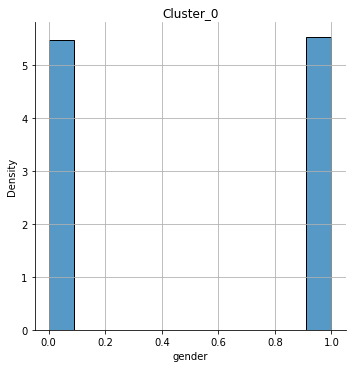

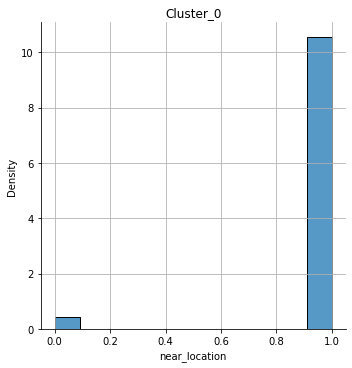

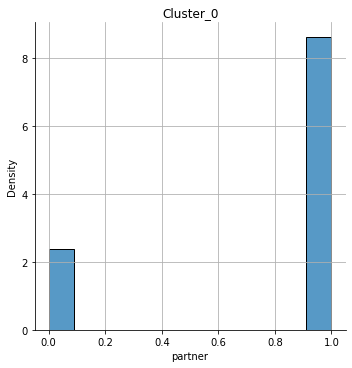

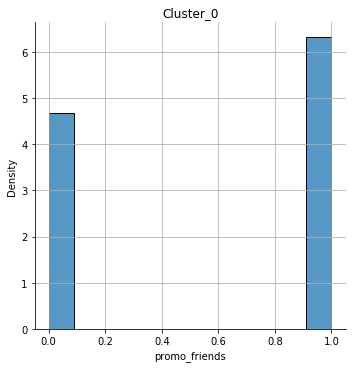

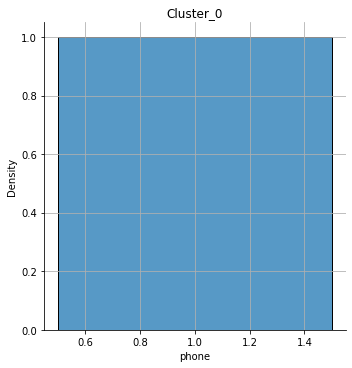

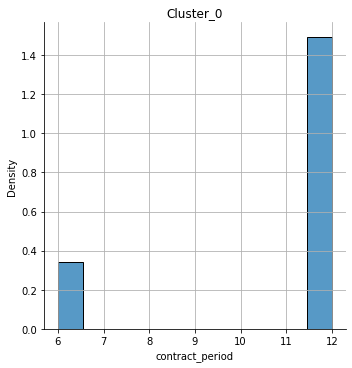

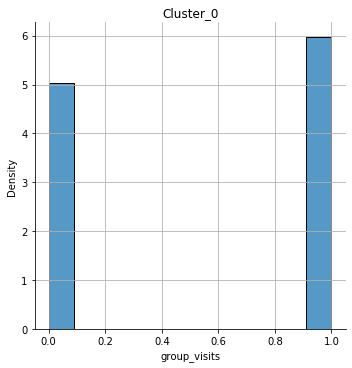

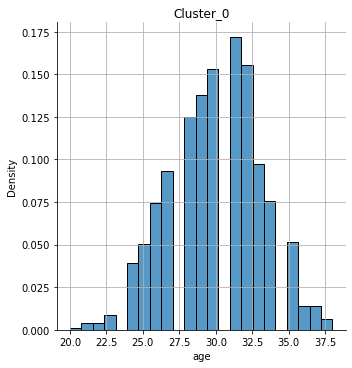

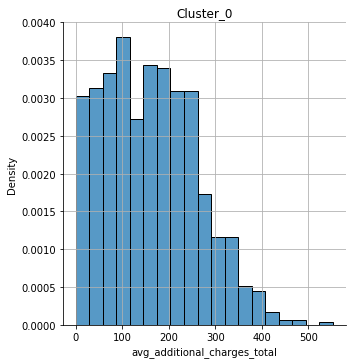

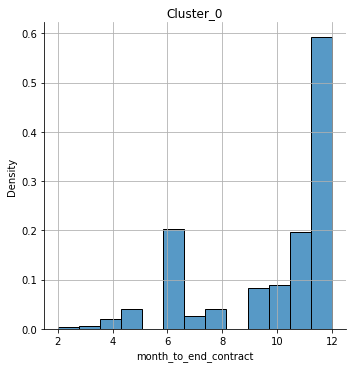

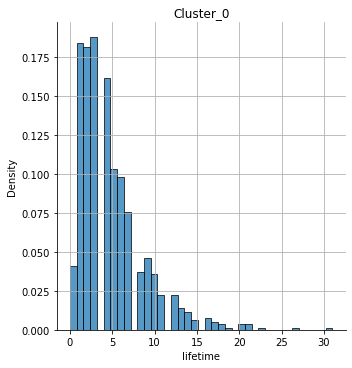

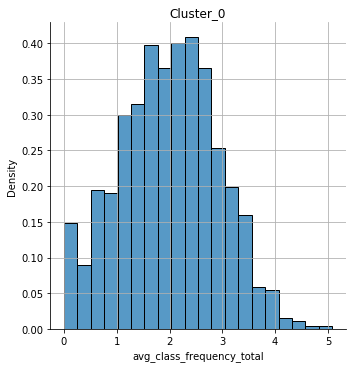

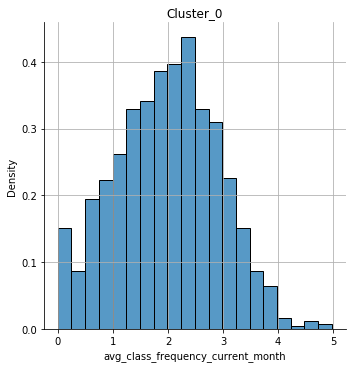

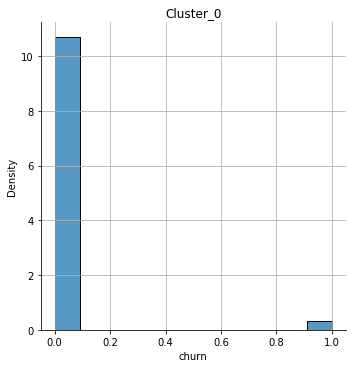

In [28]:
cluster_0 = gym_df.query('cluster_km == 0')
columns = cluster_0.columns[:-1]
fig = plt.figure(figsize=(15,10))
#axs = fig.subplots(len(columns))
for i in columns:
    sns.displot(cluster_0, x=i, stat="density", common_norm=False);
    plt.grid()
    plt.title('Cluster_0')
    plt.show()

* Распределение признаков для кластера 1.

<Figure size 1080x720 with 0 Axes>

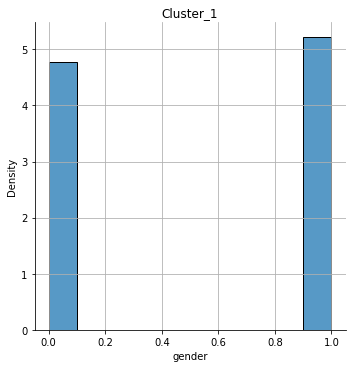

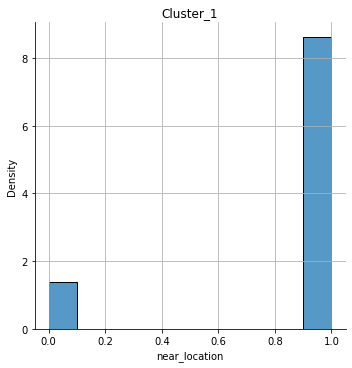

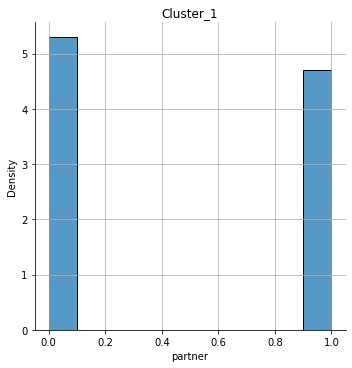

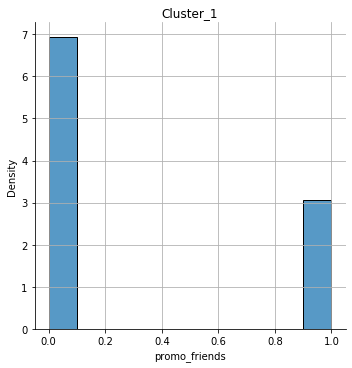

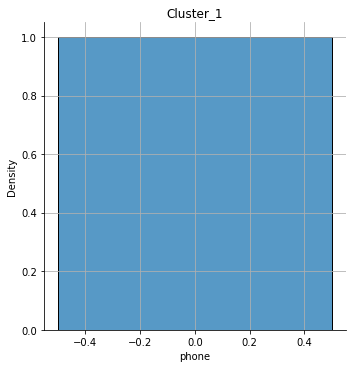

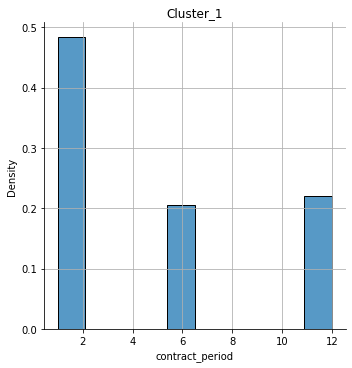

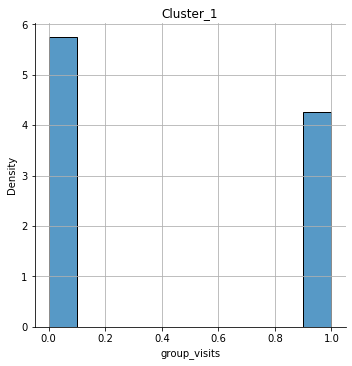

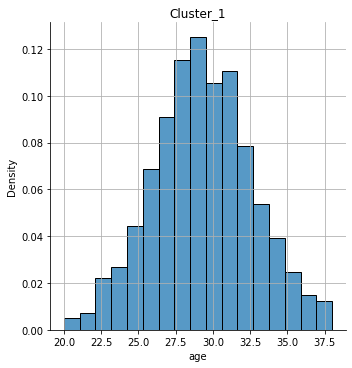

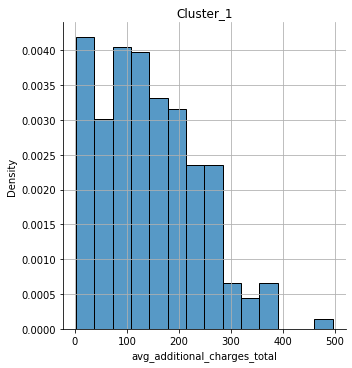

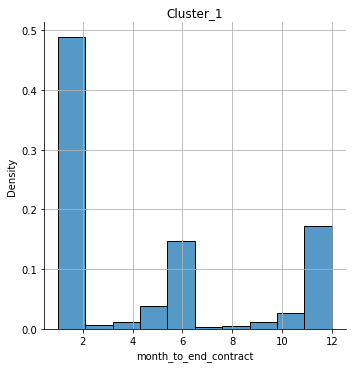

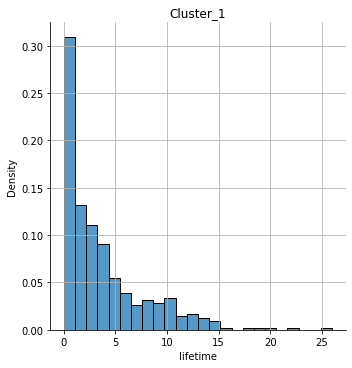

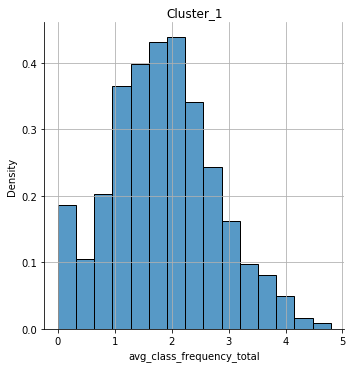

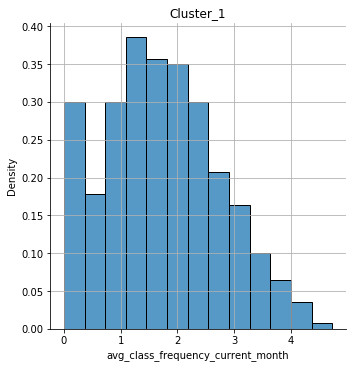

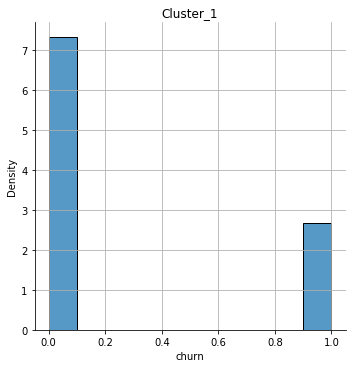

In [29]:
cluster_1 = gym_df.query('cluster_km == 1')
columns = cluster_1.columns[:-1]
fig = plt.figure(figsize=(15,10))
#axs = fig.subplots(len(columns))
for i in columns:
    sns.displot(cluster_1, x=i, stat="density", common_norm=False);
    plt.grid()
    plt.title('Cluster_1')
    plt.show()

* Распределение признаков для кластера 2.

<Figure size 1080x720 with 0 Axes>

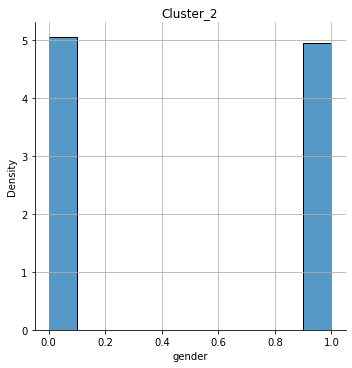

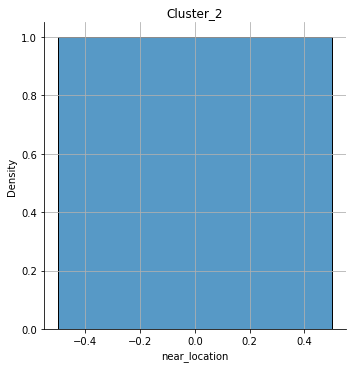

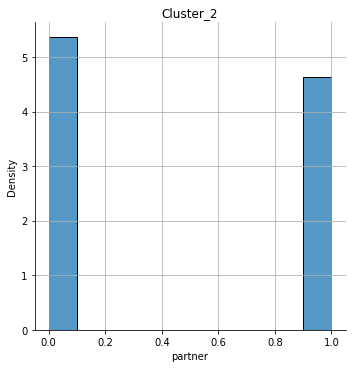

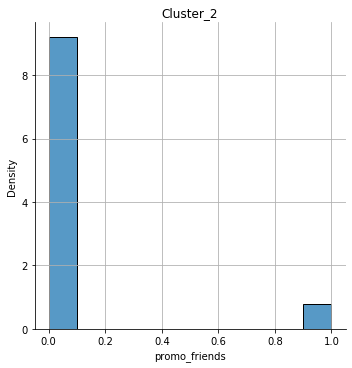

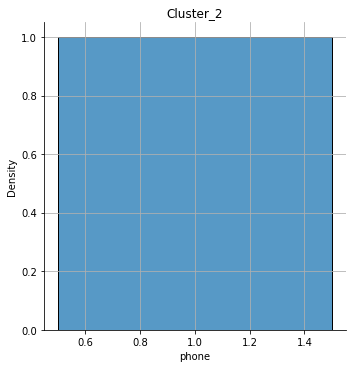

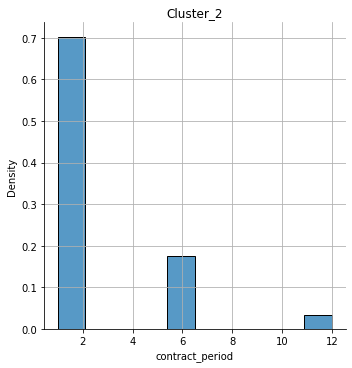

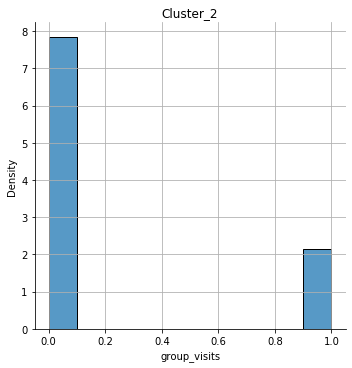

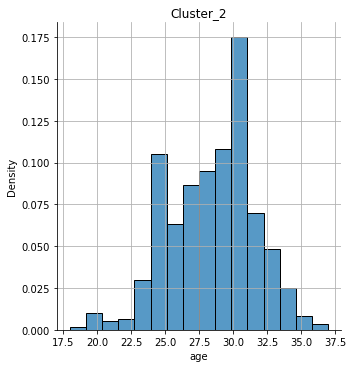

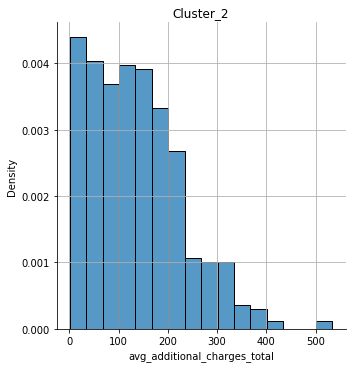

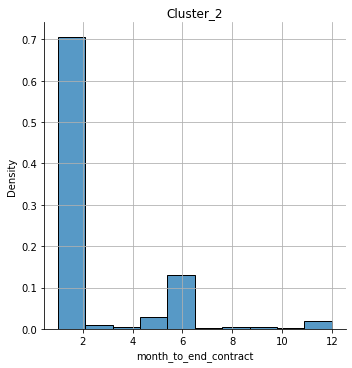

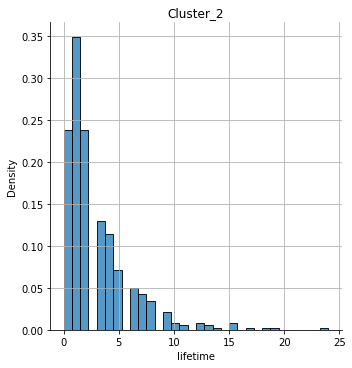

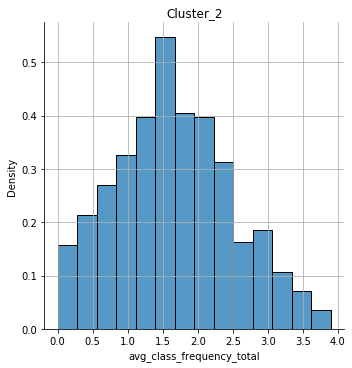

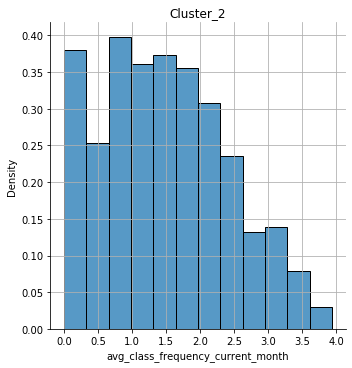

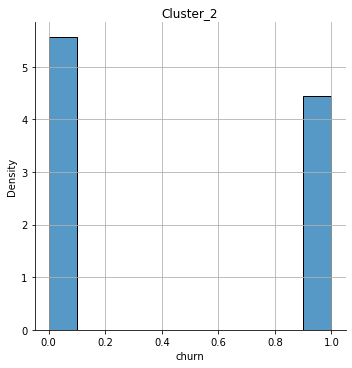

In [30]:
cluster_2 = gym_df.query('cluster_km == 2')
columns = cluster_2.columns[:-1]
fig = plt.figure(figsize=(15,10))
#axs = fig.subplots(len(columns))
for i in columns:
    sns.displot(cluster_2, x=i, stat="density", common_norm=False);
    plt.grid()
    plt.title('Cluster_2')
    plt.show()

* Распределение признаков для кластера 3.

<Figure size 1080x720 with 0 Axes>

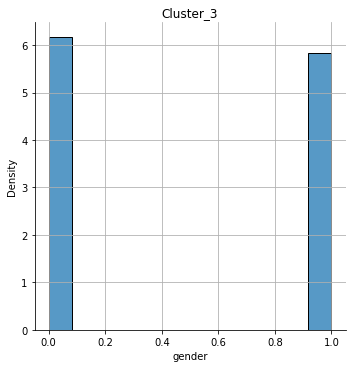

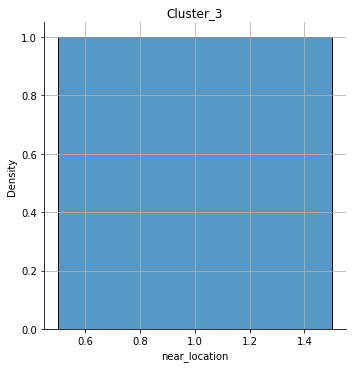

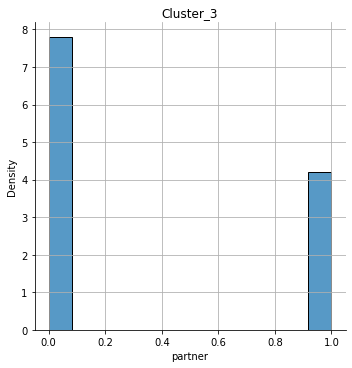

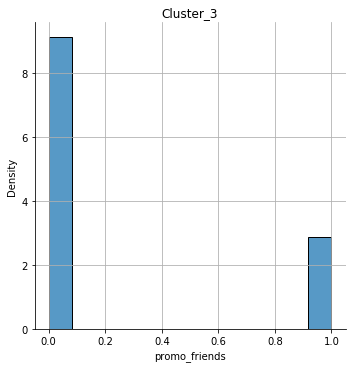

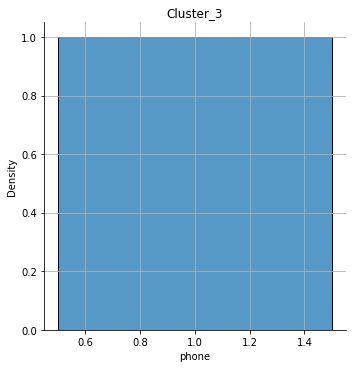

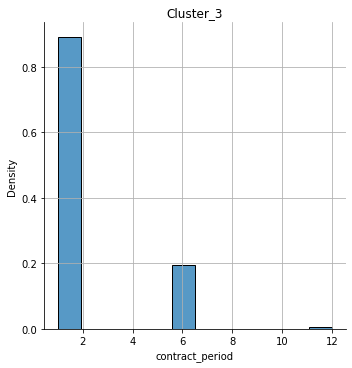

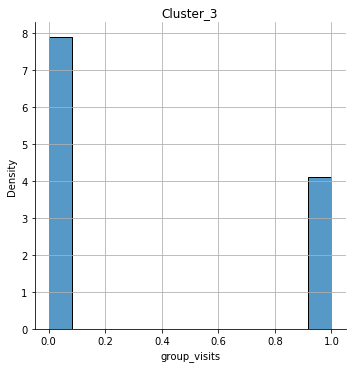

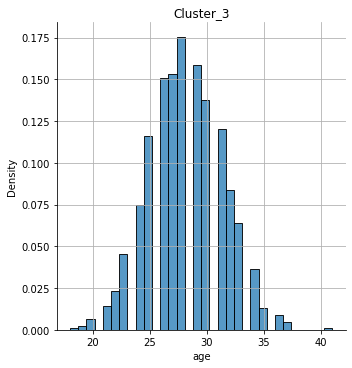

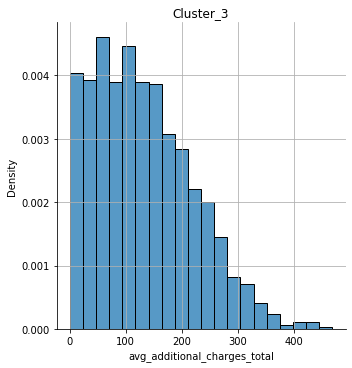

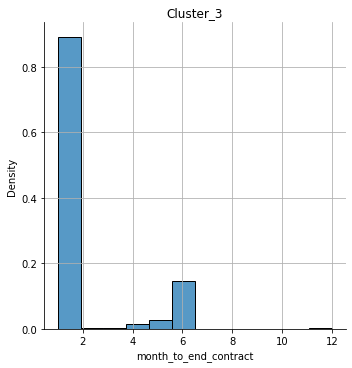

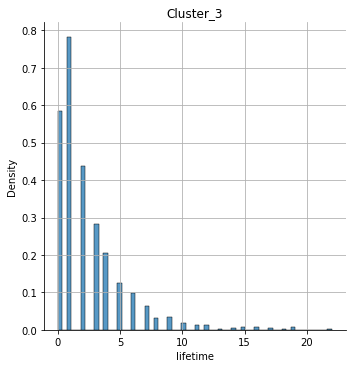

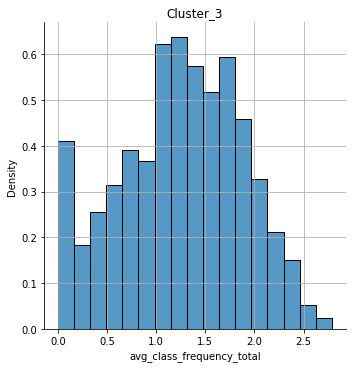

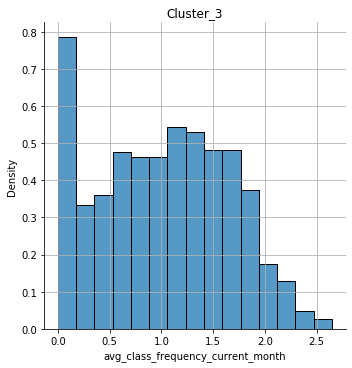

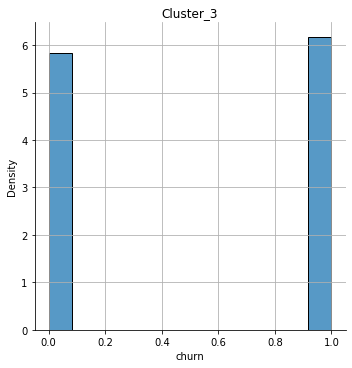

In [31]:
cluster_3 = gym_df.query('cluster_km == 3')
columns = cluster_3.columns[:-1]
fig = plt.figure(figsize=(15,10))
#axs = fig.subplots(len(columns))
for i in columns:
    sns.displot(cluster_3, x=i, stat="density", common_norm=False);
    plt.grid()
    plt.title('Cluster_3')
    plt.show()

* Распределение признаков для кластера 4.

<Figure size 1080x720 with 0 Axes>

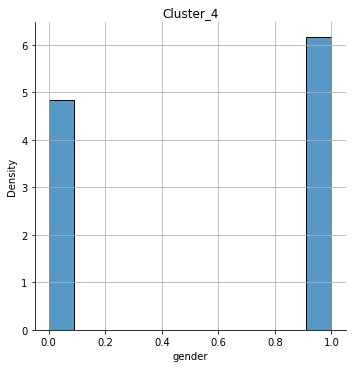

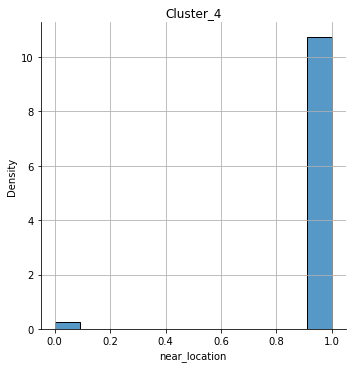

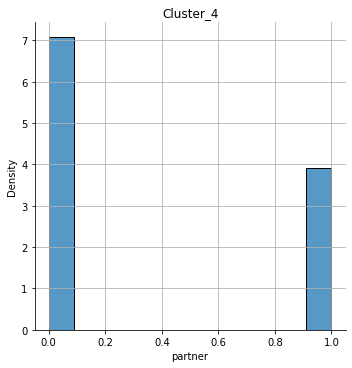

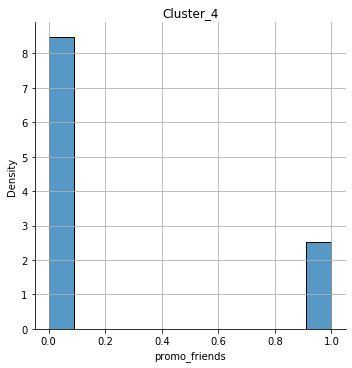

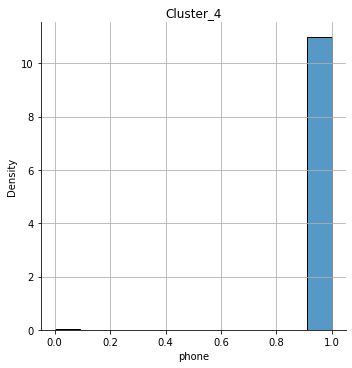

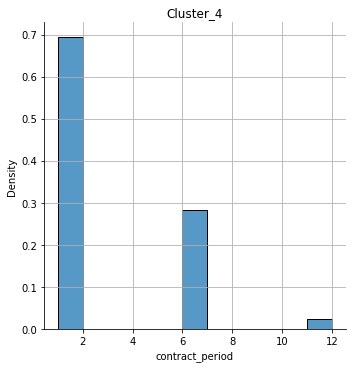

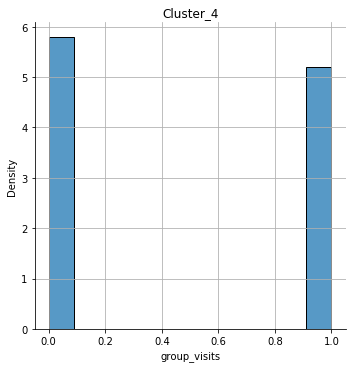

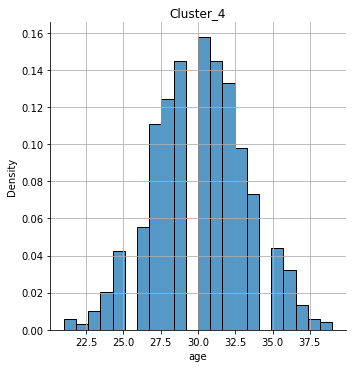

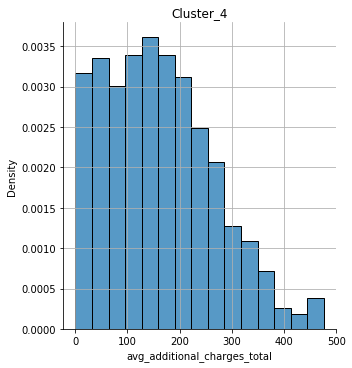

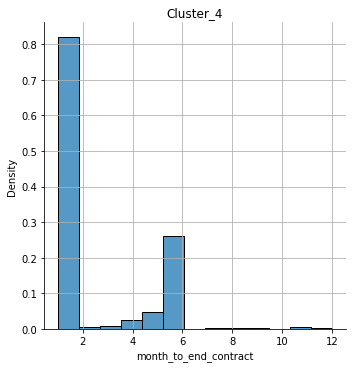

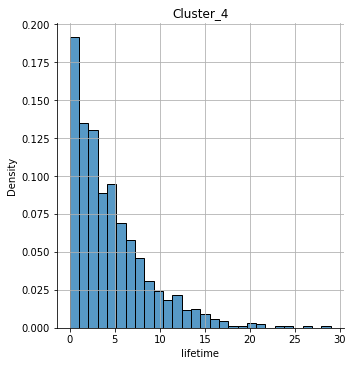

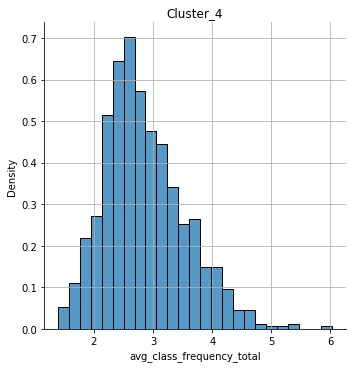

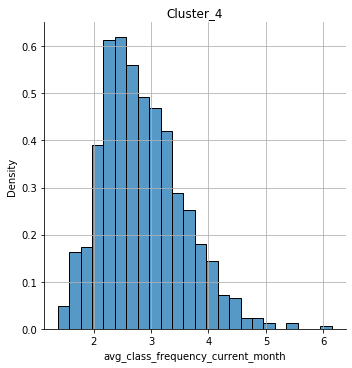

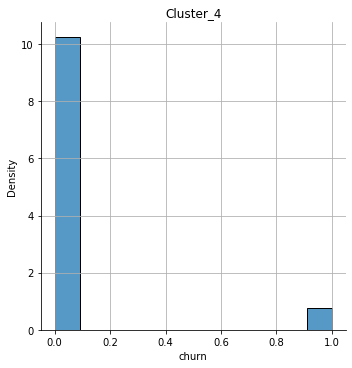

In [32]:
cluster_4 = gym_df.query('cluster_km == 4')
columns = cluster_4.columns[:-1]
fig = plt.figure(figsize=(15,10))
#axs = fig.subplots(len(columns))
for i in columns:
    sns.displot(cluster_4, x=i, stat="density", common_norm=False);
    plt.grid()
    plt.title('Cluster_4')
    plt.show()

Вывод: Судя по гистограммам, самый большой отток наблюдается в кластере номер 3.

7.5 Для каждого полученного кластера посчитаем долю оттока (методом groupby()).

In [33]:
gym_df.groupby('cluster_km')['churn'].mean().round(3).sort_values()

cluster_km
0   0.03
4   0.07
1   0.27
2   0.44
3   0.51
Name: churn, dtype: float64

Вывод: Минимальный отток в кластере с номером 0 - 3%, максимальный отток в кластере с номером 3 - 51%, что подверждается и на гистограммах выше.

7.4 Сравним кластеры с самой низкой и самой высокой долей оттока.

In [34]:
df_churn = gym_df.query('cluster_km == 0 or cluster_km == 3')
df_churn.groupby('cluster_km').mean().reset_index()

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0,0.50,0.96,0.78,0.57,1.00,10.88,0.54,29.98,160.71,9.95,4.74,1.98,1.98,0.03
1,3,0.49,1.00,0.35,0.24,1.00,1.95,0.34,28.17,131.62,1.86,2.44,1.25,1.01,0.51


Вывод: Самыми важными признаками по которым различаются кластеры является 'partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент) и promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента), факт предоставления скидки сильно влияет на удержание клиента.

### Выводы и базовые рекомендации по работе с клиентами.
<a id='cell5'></a>

Стоит выделить главные признаки для успешного удержания и привлечения клиентов. Исходя из сравнений кластеров и выделения в них более перспективных, а более перспективными считаются кластеры под номером ноль(0) и четыре(4) т.к их доля оттока составляет 3% и 7% соответсвенно и признак 'avg_additional_charges_total' - суммарная выручка от других услуг имеют самые высокие показатели, то главные признаки будут следующими:
 - 'partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент),
 - 'promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента),
 -  'group_visits' - факт посещения групповых занятий,
 - 'near_location' — проживание или работа в районе, где находится фитнес-центр.
 
 Явно, что для привлечения и удержания клиента необходимо запустить рекламу, где будет явно указан факт скидки при различного рода абонементах, а также стоит уделять больше внимания групповым занятиям, лучше для всех возрастных категорий. Близость фитнес центра также гарнтирует больший приток клиентов, стоит расширять сеть фитнес центра и выбирать для этого удобную локацию.